> **_NOTE:_** all code in this notebook is from the examples.

In [9]:
import numpy as np
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
from time import perf_counter

In [2]:
def ray(n, s, theta):
    """
    Trace ray:
        x(t) =  t*sin(theta) + s*cos(theta)
        y(t) = -t*cos(theta) + s*sin(theta)
    through volume [-1,1]^2, discretised with n x n pixels.
    
    Returns linear indices of intersected pixels and corresponding intersection lengths
    """
    
    # define boundaries of pixels
    h = 2/n
    x = -1 + np.linspace(0,n,n+1)*h
    y = -1 + np.linspace(0,n,n+1)*h
    
    # compute all intersections with horizontal and vertical grid lines
    # in terms of path length parameter t
    t = []
    if np.abs(np.sin(theta)) > 0:
        tx = (x - s*np.cos(theta))/np.sin(theta)
        t = np.concatenate((t,tx))
    if np.abs(np.cos(theta)) > 0 :
        ty = -(y - s*np.sin(theta))/np.cos(theta)
        t = np.concatenate((t,ty))
    
    # sort t in increasing order
    t = np.sort(t[np.isfinite(t)])
    
    # now trace the ray and store pixel-indices and path lengths
    nt = len(t)
    I = []
    w = []
    for i in range(nt-1):
        # entry point of ray
        x1 = t[i]*np.sin(theta) + s*np.cos(theta)
        y1 = -t[i]*np.cos(theta) + s*np.sin(theta)
        
        # exit point of ray
        x2 = t[i+1]*np.sin(theta) + s*np.cos(theta)
        y2 = -t[i+1]*np.cos(theta) + s*np.sin(theta)
        
        # pixel indices
        ix = int(((x1 + x2)/2+1)//h)
        iy = int(((y1 + y2)/2+1)//h)
        
        # only take pixels in volume [-1,1]^2 in to account
        if (0 <= ix < n) and (0 <= iy < n):
            I.append(int(iy*n + ix))
            w.append(t[i+1] - t[i])
        
    return I,w

In [3]:
def RadonMatrix(n, s, theta):
    """
    Fill (dense) matrix for given grid, detector and angles.
    """
    ns = len(s)
    nt = len(theta)
    
    A = np.zeros((ns*nt,n**2))
    for i in range(nt):
        for j in range(ns):
            J,w = ray(n, s[j],theta[i])
            A[i*ns + j,J] = w
    return A

In [14]:
def RadonSparseMatrix(n, s, theta):
    """
    Fill (sparse) matrix for given grid, detector and angles.
    """
    ns = len(s)
    nt = len(theta)
    
    I = []
    J = []
    W = []
    for i in range(nt):
        for j in range(ns):
            Jij,w = ray(n, s[j],theta[i])
            I = np.concatenate((I,len(Jij)*[i*ns + j]))
            J = np.concatenate((J,Jij))
            W = np.concatenate((W,w))
    return coo_matrix((W, (I, J)), shape=(ns*nt,n**2))

In [15]:
def Radon(u, n, s, theta):
    
    ns = len(s)
    nt = len(theta)
    # 
    f = np.zeros(ns*nt)
    
    for i in range(nt):
        for j in range(ns):
            J,w = ray(n, s[j],theta[i])
            f[i*ns + j] = np.array(w).dot(u[J])
    return f

def RadonTranspose(f, n, s, theta):
    
    ns = len(s)
    nt = len(theta)
    # 
    u = np.zeros(n*n)
    
    for i in range(nt):
        for j in range(ns):
            J,w = ray(n, s[j],theta[i])
            u[J] += np.array(w)*f[i*ns + j]
    return u

In [22]:
# Example, image on [-1,1]^2 with n pixels, detector grid [-1,1] with n samples at half gridpoints
n = 51
h = 2/n
s = np.linspace(-1+h/2,1-h/2,n)
theta = np.linspace(0,np.pi,n)

import timeit
timeit.timeit(lambda: RadonSparseMatrix(n, s, theta), number=10)

32.56463804100008

In [11]:
# Example, image on [-1,1]^2 with n pixels, detector grid [-1,1] with n samples at half gridpoints
n = 51
h = 2/n
s = np.linspace(-1+h/2,1-h/2,n)
theta = np.linspace(0,np.pi,n)
R = RadonSparseMatrix(n, s, theta)

<2601x2601 sparse matrix of type '<class 'numpy.float64'>'
	with 158139 stored elements in COOrdinate format>

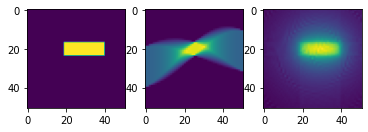

In [7]:
# Example
u = np.zeros((n,n))
u[n//2-n//6:n//3+n//7, n//2-n//8:2*n//3+n//8] = 1

#f = R@u.ravel()
f = Radon(u.ravel(), n, s, theta)
u_bp = RadonTranspose(f, n, s, theta)

fig, ax = plt.subplots(1,3)

ax[0].imshow(u)
ax[1].imshow(f.reshape((n,n)).T)
ax[2].imshow(u_bp.reshape((n,n)))

In [8]:
# adjoint test for matrix-free
u1 = np.random.randn(n*n)
f2 = np.random.randn(n*n)

f1 = Radon(u1,n,s,theta)
u2 = RadonTranspose(f2,n,s,theta)

print(u1.dot(u2)/f1.dot(f2))

0.9999999999999997
